https://www.kaggle.com/code/shivamb/semi-supervised-classification-using-autoencoders/notebook

In [31]:
import pandas as pd
import random
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

## Read csv files

In [32]:
X_train = pd.read_csv('Data/X_train.csv')
X_test = pd.read_csv('Data/X_test.csv')
Y_train = pd.read_csv('Data/Y_train.csv')
Y_test = pd.read_csv('Data/Y_test.csv')

In [33]:
X_train.head()

,index,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,3262,75.0,1,0,91.85,21.4,1,0,0,0,0,1,0,1,0,0
1,3267,2.0,0,0,99.75,16.0,1,0,0,0,0,0,0,0,0,0
2,1407,77.0,0,0,100.85,29.5,1,1,0,0,1,0,0,0,0,1
3,1385,45.0,0,0,89.05,27.8,1,1,0,0,1,0,1,1,0,0
4,3600,27.0,0,0,82.05,21.0,1,0,0,0,1,0,1,0,0,0


In [34]:
X_train.drop(['index'], axis = 1, inplace=True)
X_test.drop(['index'], axis = 1, inplace=True)
Y_train.drop(['index'], axis = 1, inplace=True)
Y_test.drop(['index'], axis = 1, inplace=True)

In [35]:
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,75.0,1,0,91.85,21.4,1,0,0,0,0,1,0,1,0,0
1,2.0,0,0,99.75,16.0,1,0,0,0,0,0,0,0,0,0
2,77.0,0,0,100.85,29.5,1,1,0,0,1,0,0,0,0,1
3,45.0,0,0,89.05,27.8,1,1,0,0,1,0,1,1,0,0
4,27.0,0,0,82.05,21.0,1,0,0,0,1,0,1,0,0,0


In [36]:
Y_train.head()

,stroke
0,0
1,0
2,0
3,0
4,0


In [38]:
sum(Y_train['stroke']==1)

194

## Condider only 500 rows of healthy cases

Combine the X_train and Y_train together before sampling.

In [41]:
merged_df = pd.concat([X_train,Y_train])

In [43]:
Y_train

,stroke
0,0
1,0
2,0
3,0
4,0
...,...
4082,0
4083,0
4084,0
4085,0


In [47]:
merged_df['stroke'].isnull().sum()

4087

In [ ]:
random.seed(10)
health = merged_df[merged_df['stroke'] == 0].sample(500)
stroke = merged_df[merged_df['stroke'] == 1]

df = health.append(stroke).sample(frac=1).reset_index(drop=True)
X = df.drop(['stroke'], axis = 1).values
Y = df["stroke"].values

/var/folders/0s/xfpwvv6x0fg3pkqm99zxr6z40000gq/T/ipykernel_62973/1891580377.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = health.append(stroke).sample(frac=1).reset_index(drop=True)


In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Health')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Stroke')

    plt.legend(loc='best')
    #plt.savefig(name)
    plt.show()

#function for plotting tsne representation

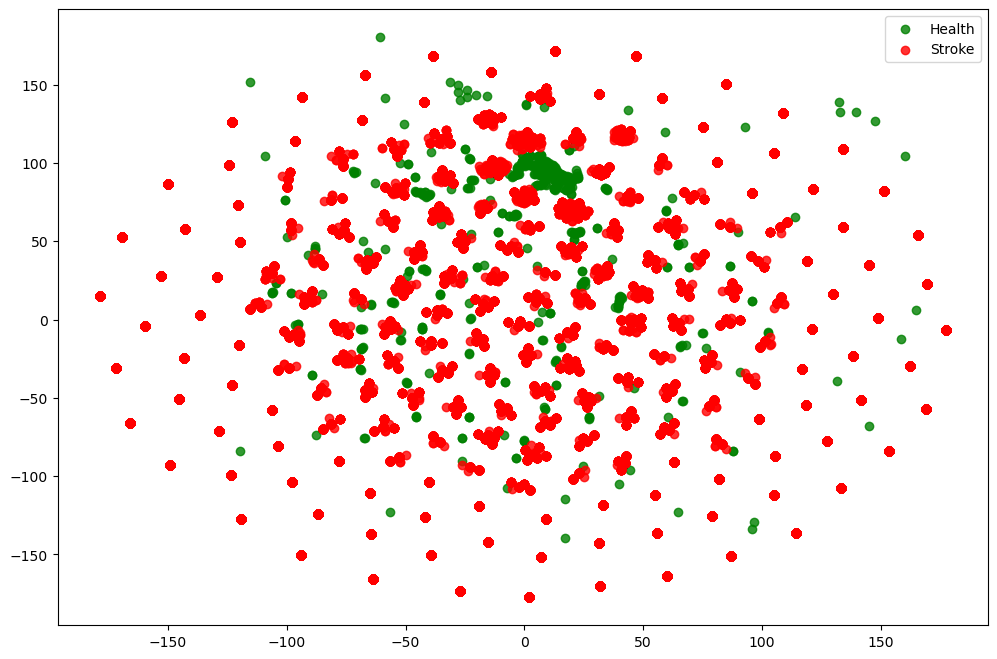

In [ ]:
tsne_plot(X, Y, "original.png")

In [ ]:
input_layer = Input(shape=(X.shape[1],))

encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

output_layer = Dense(X.shape[1], activation='relu')(decoded)

2023-03-07 18:54:15.875831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [ ]:
x_scale = preprocessing.MinMaxScaler().fit_transform(X_train.values)
x_health, x_stroke= x_scale[Y_train['stroke'] == 0], x_scale[Y_train['stroke'] == 1]

In [ ]:
autoencoder.fit(x_health[0:2000], x_health[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20)

Epoch 1/10


ValueError: in user code:

    File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 14), found shape=(None, 15)


In [ ]:
X_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked
0,75.0,1,0,91.85,21.4,0,1,0,0,0,0,1,0,1,0
1,2.0,0,0,99.75,16.0,0,1,0,0,0,0,0,0,0,0
2,77.0,0,0,100.85,29.5,0,1,1,0,0,1,0,0,0,0
3,45.0,0,0,89.05,27.8,0,1,1,0,0,1,0,1,1,0
4,27.0,0,0,82.05,21.0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,46.0,0,0,102.27,38.9,0,0,1,1,0,0,0,0,1,0
4083,81.0,0,0,89.02,26.9,0,0,1,1,0,0,0,0,0,1
4084,80.0,0,1,103.06,28.8,0,1,1,0,0,0,1,0,0,1
4085,77.0,0,0,250.80,32.9,0,1,1,0,0,1,0,1,0,1


In [ ]:
x_health.shape

(3893, 15)